In [1]:
from IPython import get_ipython


 # Projet de recherche d'information

 ## Contenu

 Ce notebook et les scripts supports reprennent la méthodologie des labs 1 à 3 avec les différences suivantes:
 + **Traitement des requêtes**: La fonction pre_processed_query du Lab2 contient un bug qui a été corrigé. Le problème était que la lemmatisation se faisait après avoir retirer les termes de la requête absents de l'index inversé qui ne contient aucun mot dont le pluriel modifie l'orthographe à cause de la lemmatisation de l'index, ainsi la fonction pre_processed_query retire des mots au pluriel. Par exemple, le mot students n'apparaît pas dans l'index et est retiré par pre_proessed_query dans la requête 'stanford students'
 + ** Modèles booléens ** :
   + A défaut de pouvoir utiliser le module tt pour le passage d'une expression en postfix, un code python disponible sur le net, pour les expressions algèbriques, a été adapté pour les opérations booléennes AND, OR et NOT entre termes de la requête. Le code est disponible  dans le fichier infix_postfix.py
 + ** Modèles vectoriels ** :
   + Le modèle tw-idf correspondant à l'article présenté est implémenté et évalué. L'implémentation du comptage des degrés entrant est dans ce notebook, mais la fonction de calcul de tw-idf est mise à la suite des autres modèles dans le fichier Lab2.py
   + Il semble y'avoir un bug dans la fonction processing_vectorial_query du corrigé du Lab 2. En effet, l'affectation relevant_docs`[doc]` = 0. remet à zéro le score du document alors qu'il faudrait sommer sur tous les termes de la requête que celui-ci contient. Le code a été corrigé dans ce sens.
 + ** Modèles probabilistes **:
   + Les modèles MIB et OKAPI BM 25 sont implémentés.


 ## Exécution du notebook

 Les cellules ou les calculs peuvent êtres longs comme le prétraitement de la collection auront les résultats chargés depuis un fichier par défaut, mais vous avez la possibilité de tester ces prétraitements en passant la variable booléenne ** recompute ** à True dans la cellule.

 Comme demandé, les évaluations sont présentés pour les requêtes 2,3,4 et 8 avec à la fin la possibilité d'obtenir les documents pertinents pour la concaténation des requêtes précédentes.

 Tous les scripts et fichiers chargé sont dans le dossier de ce notebook.

 ### PRETRAITEMENT ET STATISTIQUES DE LA COLLECTION

 **1. Chargement de l'index inversé avec fréquences des termes et du dictionnaire {id: doc_filename}, de l'index non inversé**

In [2]:
from Lab1 import load_pickle, save_pickle

# passer recompute à True pour refaire les prétraitements
recompute = False

if not recompute:
    id_to_filename_map = load_pickle("id_to_filename_map.pkl")
    inverted_index = load_pickle("inverted_index.pkl")
    corpus = load_pickle("corpus.pkl")

else:
    from Lab1 import *
    directory = 'data'
    corpus, id_to_filename_map = loadData(directory)
    stop_words = load_stop_word(
        'TIME.STP')
    stop_words = [x.lower() for x in stop_words]
    corpus = tokenize_Regexp_corpus(corpus)
    corpus = remove_stop_words(corpus, stop_words)
    corpus = collection_stemming(corpus)
    corpus = collection_lemmatize(corpus)
    corpus = remove_empty_docs(corpus)
    save_pickle(corpus, "corpus.pkl")
    inverted_index = build_inverted_index(corpus, type_index=2)
    save_pickle(inverted_index, "inverted_index.pkl")

 **2. Chargement des statistiques de la collection**


In [3]:

recompute = False

if not recompute:
    stats_collection = load_pickle(
        'stats.pkl')

else:
    from Lab2 import *
    stats_collection = get_stats_collection(corpus)
    save_pickle(stats_collection, 'stats.pkl')

general_stats = ["nb_docs", 'longueur_doc_moyenne']
print('statistiques globales')
for key in general_stats:
    print(key, stats_collection[key])
print('')
print('statistiques par document, example du document ' +
      id_to_filename_map[0])
for key in stats_collection[0]:
    print(key, stats_collection[0][key])

statistiques globales
nb_docs 98996
longueur_doc_moyenne 178.62535860034748

statistiques par document, example du document 0/3dradiology.stanford.edu_
freq_max 13
unique_terms 143
length 273
freq_moy 1.9090909090909092


 **3. Chargement des jugements de pertinence et des requêtes**

In [4]:


def load_relevance_judgments(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        relevance_judgments = {}
        for line in lines:
            line = line.split()
            if len(line) > 0:
                key = line[0]
                s = set()
                for l in line[1:]:
                    s.add(l)
                relevance_judgments[key] = s
        return relevance_judgments


def load_relevance_judgments_with_doc_ids(query_filename, relevance_filename, id_to_filename_map):
    '''we reverse the id_to_filename_map'''
    filename_to_id_map = {v: k for k, v in id_to_filename_map.items()}

    query = ''
    '''we read the query'''
    with open(query_filename) as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) > 0:
                query = query + line
        f.close()
    '''we read the relevance judgments'''
    docs = set()
    with open(relevance_filename) as f:
        for line in f.readlines():
            line = line.rstrip()
            filename = line
            if filename in filename_to_id_map:
                i = filename_to_id_map[filename]
                docs.add(i)
        f.close()
    return(query, docs)


def load_relevance_judgments_with_doc_ids_for_all_queries(query_dirname, relevance_dirname, filename_to_id_map, query_ids=list(range(1, 9))):
    query_filenames = []
    for i in query_ids:
        query_filename = query_dirname + '/query.' + str(i)
        query_filenames.append(query_filename)

    relevance_filenames = []
    for i in query_ids:
        relevance_filename = relevance_dirname + '/' + str(i) + '.out'
        relevance_filenames.append(relevance_filename)

    relevance_judgments = {}
    for i in range(len(query_filenames)):
        query_filename = query_filenames[i]
        relevance_filename = relevance_filenames[i]
        query, docs = load_relevance_judgments_with_doc_ids(
            query_filename, relevance_filename, filename_to_id_map)
        relevance_judgments[query] = docs

    return (relevance_judgments)



 Exécution des chargements des requêtes et jugements de pertinence

In [5]:
query_dirname = 'Queries/dev_queries'
relevance_dirname = 'Queries/dev_output'
relevance_judgments = load_relevance_judgments_with_doc_ids_for_all_queries(
    query_dirname, relevance_dirname, id_to_filename_map, query_ids=[2, 3, 4, 8])
requests = relevance_judgments.keys()
print('requests', requests)


requests dict_keys(['stanford class', 'stanford students', 'very cool', 'stanford computer science'])


 **4. TW-IDF: Fonctions de chargement de l'index inversé avec degrés entrant**

In [6]:


def get_document_indegree_map(document, window=4):
    '''prend un document en argument et renvoie un dictionnaire donnant le degré
    entrant pour chaque term du document'''

    indegree_map = {}
    for i in range(1, len(document)):
        term_i = document[i]
        if not term_i in indegree_map:
            indegree_map[term_i] = set()
        for j in range(max(i - 3, 0), i):
            term_j = document[j]
            indegree_map[term_i].add(term_j)
    for term in indegree_map:
        indegree_map[term] = len(indegree_map[term])
    return (indegree_map)


def get_corpus_indegree_map(corpus):
    '''corpus est un dictionnaire id: document_texte
    on renvoit un dictionnaire id: indegree_map'''
    res_map = {}
    for key in corpus:
        doc = corpus[key]
        indegree_map = get_document_indegree_map(doc)
        res_map[key] = indegree_map
    return(res_map)


def inverse_indegree_corpus(corpus):
    inverted_map = {}
    for doc_id in corpus:
        indegree_map = corpus[doc_id]
        for term in indegree_map:
            indegree = indegree_map[term]
            if not term in inverted_map:
                inverted_map[term] = {}
            inverted_map[term][doc_id] = indegree
    return(inverted_map)


 Chargement ou recalcul du résultat de l'index de degrés entrant

In [7]:


recompute = False

if not recompute:
    indegree_corpus = load_pickle('indegree_index.pkl')
else:
    indegree_corpus = get_corpus_indegree_map(corpus)
    indegree_corpus = inverse_indegree_corpus(indegree_corpus)
    save_pickle(indegree_corpus, 'indegree_index.pkl')

print('Exemple')
for key in indegree_corpus:
    for doc in indegree_corpus[key]:
        print('Le terme ' + key + ' a un degré entrant de ' +
              str(indegree_corpus[key][doc]) + ' dans le document' + id_to_filename_map[doc])
        print('')
        break
    break

print('')
print('On peut le vérifier avec le contenu du document ' +
      id_to_filename_map[doc] + ' et en utilisant ctrl+f; les 6 connections entrantes viennent de 3d, quantit, imag, depart, medicin, school')

print(corpus[doc])

Exemple
Le terme radiolog a un degré entrant de 6 dans le document0/3dradiology.stanford.edu_


On peut le vérifier avec le contenu du document 0/3dradiology.stanford.edu_ et en utilisant ctrl+f; les 6 connections entrantes viennent de 3d, quantit, imag, depart, medicin, school
['3d', 'radiolog', 'lab', 'stanford', 'univers', 'school', 'medicin', 'stanford', 'school', 'medicin', '3d', 'quantit', 'imag', 'depart', 'radiolog', 'search', 'site', 'stanford', 'medic', 'site', 'way', 'person', 'alumnus', 'lane', 'librari', 'way', 'person', 'mission', 'develop', 'appli', 'innov', 'techniqu', 'effici', 'quantit', 'analysi', 'display', 'medic', 'imag', 'data', 'interdisciplinari', 'collabor', 'goal', 'educ', 'train', 'physician', 'technologist', 'local', 'worldwid', 'latest', 'develop', '3d', 'quantit', 'imag', 'research', 'develop', 'new', 'approach', 'explor', 'analysi', 'quantit', 'ass', 'diagnost', 'imag', 'result', 'new', 'cost', 'effect', 'diagnost', 'approach', 'new', 'techniqu', 'design

 ### EVALUATION DE RÉSULTATS DE RECHERCHE NON ORDONNÉS
 ### MODÈLE BOOLÉEN


 On sauvegardera les résultats de l'évaluation sous la forme d'un dictionnaire avec comme clé la requête et comme valeur un dictionnaire avec une clé par type de mesure et en valeur le résultat de la mesure calculé sur les documents renvoyés par requête. On calculera en particulier pour chaque requête :
 + son rappel
 + sa précision
 + la mesure F_1
 + la mesure F avec un paramètre $\beta = 2$


 On considérera les relations AND et OR et on fait un prétraitement des requêtes qui consiste à, tokéniser, lemmatiser, filtrer les termes absent du vocabulaires et les 'stop words' et passer les lettres en minuscules.

In [8]:
from Lab2 import transformation_lem_query_to_boolean, transformation_query_to_boolean, processing_boolean_query_with_inverted_index
from Lab2 import pre_processed_query
from infix_postix import transformation_query_to_postfixe


def tranformation_query(query, operator):
    if type(query) == str:
        res = transformation_query_to_boolean(query, operator)
    else:
        res = transformation_lem_query_to_boolean(query, operator)
    res = transformation_query_to_postfixe(res)

    return (res)


def generate_default_bool_filtered_requests_old(requests, collection_index, operator):
    processed_requests = {}
    for request_key in requests:

        request = requests[request_key]
        remaining_request = []
        for word in request:

            if word in collection_index and word != 'U.S':
                remaining_request.append(word)
        remaining_request = tranformation_query(remaining_request, operator)
        processed_requests[request_key] = remaining_request
    return(processed_requests)


def generate_default_bool_filtered_requests(requests, collection_index, operator):

    processed_requests = {}
    for request in requests:
        processed_request = pre_processed_query(request, collection_index)
        remaining_request = tranformation_query(processed_request, operator)

        processed_requests[request] = remaining_request
    return(processed_requests)


def estimate_relevant_docs(bool_requests, collection_index, BooleanOperator={'AND', 'OR', 'NOT'}):

    relevant_docs_dic = {}
    for query_key in bool_requests:
        query = bool_requests[query_key]
        relevant_docs = processing_boolean_query_with_inverted_index(
            BooleanOperator, query, collection_index)
        relevant_docs_dic[query_key] = relevant_docs
    return relevant_docs_dic


def get_stats(estimate, real, beta=2):
    '''les arguments estimate et real sont des listes de documents pertinents
    on obtient ainsi les statistiques pour une seule requête'''
    s1 = set(estimate)
    s2 = set(real)

    s_inter = s1.intersection(s2)
    precision = 1 if len(s1) == 0 else len(s_inter) / len(s1)
    recall = 1 if len(s2) == 0 else len(s_inter) / len(s2)
    F1 = 0 if precision + recall == 0 else 2 * \
        precision * recall / (precision + recall)
    F_beta = 0 if precision + \
        recall == 0 else (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    stat_names = ['precision', 'recall', 'F_1', 'F']
    stat_values = [precision, recall, F1, F_beta]
    stats = {}
    for i in range(len(stat_names)):
        stats[stat_names[i]] = stat_values[i]
    return(stats)


def evaluate_boolean_model(bool_requests, collection_index, relevance_judgments, BooleanOperator={'AND', 'OR', 'NOT'}):
    '''permet d'avoir les statistiques pour l'ensemble des requêtes du corpus'''
    relevant_docs = estimate_relevant_docs(
        bool_requests, collection_index, BooleanOperator={'AND', 'OR', 'NOT'})

    query_to_stats_map = {}
    for query in relevant_docs:
        estimate = relevant_docs[query]
        real = relevance_judgments[query]
        stats = get_stats(estimate, real)
        query_to_stats_map[query] = stats

    return (query_to_stats_map)


def get_boolean_relevant_docs(query, collection_index, operator, BooleanOperator={'AND', 'OR', 'NOT'}):
    bool_query = tranformation_query(query, operator)
    relevant_docs = processing_boolean_query_with_inverted_index(
        BooleanOperator, bool_query, collection_index)

    return relevant_docs



 **Modèle 'OR'**

In [9]:
import pprint


operator = 'OR'
bool_requests = generate_default_bool_filtered_requests(
    requests, inverted_index, operator)
stats = evaluate_boolean_model(bool_requests=bool_requests,
                               collection_index=inverted_index, relevance_judgments=relevance_judgments)

print('Requêtes booléennes \n')
pprint.pprint(bool_requests)
print('')
print('Résultats des métriques pour chaque requête \n')
pprint.pprint(stats)


Requêtes booléennes 

{'stanford class': ['stanford', 'class', 'OR'],
 'stanford computer science': ['stanford', 'computer', 'OR'],
 'stanford students': ['stanford', 'student', 'OR'],
 'very cool': ['cool']}

Résultats des métriques pour chaque requête 

{'stanford class': {'F': 0.31226941051078133,
                    'F_1': 0.1537064595051328,
                    'precision': 0.08325136612021858,
                    'recall': 1.0},
 'stanford computer science': {'F': 0.23981565771506594,
                               'F_1': 0.11212492019578635,
                               'precision': 0.05940635922877438,
                               'recall': 0.9959829867674859},
 'stanford students': {'F': 0.6878657222051123,
                       'F_1': 0.4685090985368923,
                       'precision': 0.30591699767155184,
                       'recall': 1.0},
 'very cool': {'F': 0.30493707647628265,
               'F_1': 0.14928909952606637,
               'precision': 0.0806658130

 **Modèle 'AND'**

In [10]:


operator = 'AND'
bool_requests = generate_default_bool_filtered_requests(
    requests, inverted_index, operator)
stats = evaluate_boolean_model(bool_requests=bool_requests,
                               collection_index=inverted_index, relevance_judgments=relevance_judgments)

print('Requêtes booléennes \n')
pprint.pprint(bool_requests)
print('')
print('Résultats des métriques pour chaque requête \n')
pprint.pprint(stats)

Requêtes booléennes 

{'stanford class': ['stanford', 'class', 'AND'],
 'stanford computer science': ['stanford', 'computer', 'AND'],
 'stanford students': ['stanford', 'student', 'AND'],
 'very cool': ['cool']}

Résultats des métriques pour chaque requête 

{'stanford class': {'F': 0.933402769268472,
                    'F_1': 0.8486283247458571,
                    'precision': 0.7370585389453314,
                    'recall': 1.0},
 'stanford computer science': {'F': 0.0017679297542577647,
                               'F_1': 0.002808331383103206,
                               'precision': 0.14634146341463414,
                               'recall': 0.0014177693761814746},
 'stanford students': {'F': 0.9521353238581624,
                       'F_1': 0.8883541484368785,
                       'precision': 0.7991341371784322,
                       'recall': 1.0},
 'very cool': {'F': 0.30493707647628265,
               'F_1': 0.14928909952606637,
               'precision': 0.08066

 Premier constat, pour la requête 'very cool' qui se réduit au terme 'cool' donne les mêmes résultats pour le modèle OR et AND ce qui est normal, le recall est de 1 mais la précision est faible.
 On retrouve des résultats cohérents avec le fait que le modèle OR possède un recall proche de 1 pour l'ensemble des requêtes mais une mauvaise précision: tous les modèles pertinents sont inclus dans la réponse mais la grande majorité de ces documents ne sont pas pertinents.
 Pour le modèle AND la précision est meilleure et le recall est de 1 pour les requêtes stanford class et stanford students. Mais le recall est mauvais pour stanford computer science et la précision aussi.

 Interprétations:
 + La requête 'very cool': ce résultat montre que les documents pertinents sont tous dans les document contenant le terme cool. Mais la majeure partie de ces documents ne correspondent pas aux attentes de la requête.
 + La requête 'stanford computer science': Même constat, mais en plus, cette requête permet de voir le compromis qu'il faut faire entre OR et AND car même si la précision est basse pour AND, elle meilleure qu'avec OR.

 Cependant on peut avoir un doute pour la requête 'stanford computer science', est-ce que le termes 'computer', qu'on peut considérer plus porteur de sens, est le terme qui permet d'avoir un recall de 1 et donc d'inclure l'ensemble des documents pertinents? La réponse est non, on peut le vérifier en retirant le terme stanford de l'ensemble des requêtes en gardant les mêmes jugements de pertinence avec le code de la cellule ci-dessous:


In [11]:

# On redéfinie cette fonction pour retirer
# le premier terme des requêtes qui est stanford ici
# on ignore également la requête very cool


def generate_default_bool_filtered_requests_bis(requests, collection_index, operator):

    processed_requests = {}
    for request in requests:
        if request == 'very cool':
            continue
        processed_request = pre_processed_query(request, collection_index)
        if len(processed_request) > 1:
            processed_request = processed_request[1:]
        remaining_request = tranformation_query(processed_request, operator)

        processed_requests[request] = remaining_request
    return(processed_requests)


operator = 'OR'
bool_requests = generate_default_bool_filtered_requests_bis(
    requests, inverted_index, operator)
stats = evaluate_boolean_model(bool_requests=bool_requests,
                               collection_index=inverted_index, relevance_judgments=relevance_judgments)

new_stats = {}
for query in stats:
    new_query = ' '.join(query.split()[1:])
    new_stats[new_query] = stats[query]

print('Requêtes booléennes \n')
pprint.pprint(bool_requests)
print('')
print('Résultats des métriques pour chaque requête \n')
pprint.pprint(new_stats)


Requêtes booléennes 

{'stanford class': ['class'],
 'stanford computer science': ['computer'],
 'stanford students': ['student']}

Résultats des métriques pour chaque requête 

{'class': {'F': 0.8811961362716179,
           'F_1': 0.7479135984290624,
           'precision': 0.5973338561066458,
           'recall': 1.0},
 'computer science': {'F': 0.0017664723547076487,
                      'F_1': 0.002799160251924423,
                      'precision': 0.10909090909090909,
                      'recall': 0.0014177693761814746},
 'students': {'F': 0.9382403844538169,
              'F_1': 0.8586916822052634,
              'precision': 0.7523748568348717,
              'recall': 1.0}}



 Il sera donc très difficile pour un modèle qui se base seulement sur les termes de la requêtes, du style TF-IDF, de récupérer des documents pertinents pour la requête 'stanford computer science' vu que le recall pour la requête 'computer science' seul est de 0.001, cela veut dire que la quasi totalité des documents récupérés par la requête de départ sont dûes uniquement à la présence du terme 'stanford'. Autrement dit il ne devrait pas y avoir de grande différence pour les documents sélectionnés entre la requête 'stanford computer science' et la requête 'stanford' pour les modèles de scoring vus dans la suite car quasiment aucun document pertinent ne possède le terme 'computer'.

 Conclusions sur la requêtes:
 + Le mauvais recall de la requête 'computer' implique que la quasi totalité (99.9%) des documents liés à l'idée de computer science exprime ce terme avec un vocabulaire différent du terme 'computer', c'est le premier problème.
 + La mauvaise précision montre que 85 % des documents utilisant le terme de computer ne sont pas liés à l'idée de computer science. Par exemple, on peut parler d'ordinateur sans parler de programmation.
 + Au vu de ces deux conclusions, les modèles étudiés dans la suite, qui se basent sur la présence des termes des requêtes dans les documents pour renvoyer des documents pertinents et les classés, auront à priori une mauvaise performance sur cette requête.
 + Par contre, le recall de 1 conservé pour les requêtes 'class' et 'students' ce qui montre qu'on continue d'englober l'ensemble des documents pertinents et que les termes 'class' et 'students' auront un rôle significatif dans le scoring des documents des modèles dans la suite du notebook. Notons aussi que les requêtes sont maintenant à un terme seulement donc qu'il n'y a pas de différence entre les modèles OR et AND. Ainsi on peut comparer les précisions avec celle qu'on trouve en appliquant le modèle AND sur les requêtes avec stanford et voir qu'on a une baisse de précision lorsqu'on retire stanford.

 ### EVALUATION DE RÉSULTATS ORDONNÉS

 Dans la suite on étudie les métriques de précision rappel et précision moyenne pour les modèles suivants
   + La pondération `tf`.
   + La pondération `tf-idf`.
   + La pondération `tf-idf` normalisée.
   + La pondération `tf-idf` logarithmique.
   + La pondération `tf-idf` logarithmique normalisée.
   + La pondération `tw-idf`
   + le modèle `MIB`
   + le modèle `BM25`


 Pour le modèle MIB, on fait l'approximation $c_{j} = \log{\frac{p_{j}(1-s_{j})}{s_{j}(1-p_{j})}}$

 Avec les estimations $\log{\frac{1-s_{j}}{s_{j}}} = \log{\frac{N}{df_{j}}}$ et $pj = k*\frac{df_{j}}{N}$ en prenant arbitrairement $k=1$ ici

 Pour le modèle Okapi BM25 nous prenous les valeurs par défaut suggérées dans le cours pour les hyperparamètres

 #### Courbe Rappel-Précision


 Ci-dessous on définit une fonction qui renvoie une fonction à partir d'un nom de modèle et une fonction qui renvoit les valeurs de précisions et rappel à chaque document pertinent

 Il est possible de choisir un modèle pour les requêtes qui peut être fréquentiel ou binaire. On ne montre les résultats que pour le cas binaire car toutes les requêtes testées n'ont pas de répétition.

In [12]:
from Lab2 import processing_vectorial_query

model_list = ['bool_and', 'bool_or']

# la liste des modèles qui renvoient des documents pertinents ordonnés
ordered_model_list = ["binary", "frequency", "tf_idf_normalize",
                      "tf_idf_logarithmic", "tf_idf_logarithmic_normalize",
                      'tw_idf', 'mib', 'bm25']

query_model_list = ["binary", "frequency"]


def get_model(model_name, query_model='binary', stats_collection=None, index_weight=None):
    vectorial_query_model_list = ["binary", "frequency", "tf_idf_normalize",
                                  "tf_idf_logarithmic", "tf_idf_logarithmic_normalize",
                                  'tw_idf', 'mib', 'bm25']
    if model_name == 'bool_and':
        def f(query, inverted_index):
            query = pre_processed_query(query, inverted_index)
            return(get_boolean_relevant_docs(query, inverted_index, operator='AND'))
        return(f)

    if model_name == 'bool_or':
        def f(query, inverted_index):
            query = pre_processed_query(query, inverted_index)
            return get_boolean_relevant_docs(query, inverted_index, operator='OR')
        return(f)

    if model_name in vectorial_query_model_list:
        def f(query, inverted_index):
            return processing_vectorial_query(query, inverted_index, stats_collection=stats_collection, weighting_scheme_document=model_name, weighting_scheme_query=query_model, index_weight=index_weight)
        return(f)


def run_model_and_evaluate(query, inverted_index, model, relevance_judgments):
    '''Renvoie les informations nécessaires pour tracer une courbe précision rappelle 
    dans le cas d'un model ordonné'''
    sorted_estimate = model(query, inverted_index)
    relevance_judgments = relevance_judgments[query]

    n_relevant_docs = len(relevance_judgments)
    n_estimated_docs = len(sorted_estimate)

    correct_doc_inc = 0
    doc_inc = 0

    precision_list = []
    recall_list = []

    filename = 'debug.pkl'
    save_pickle(sorted_estimate, filename)

    for doc in sorted_estimate:

        if doc in relevance_judgments:
            precision = (correct_doc_inc + 1) / (doc_inc + 1)
            recall = (correct_doc_inc + 1) / (n_relevant_docs)

            precision_list.append(precision)
            recall_list.append(recall)

            correct_doc_inc += 1
            doc_inc += 1
        else:
            doc_inc += 1

    return(precision_list, recall_list)



 Fonction pour tracer la courbe précision rappel

In [13]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def draw_recall_precision_curve(query, inverted_index, model, relevance_judgments, model_name=None, linestyle=None):
    precision_list, recall_list = run_model_and_evaluate(
        query, inverted_index, model, relevance_judgments)
    plt.plot(recall_list, precision_list,
             label=model_name, linestyle=linestyle)



 On trace la courbe précision-rappel pour tous les modèles et chaque requête, on voit que les modèles sont plus ou moins performants en fonction des requêtes et on voit des différences de performance entre les modèles.


Requête:  stanford class


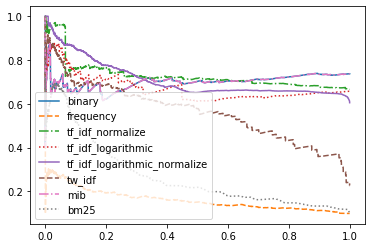

Requête:  stanford students


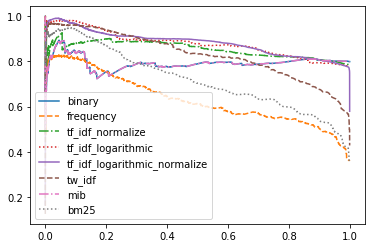

Requête:  very cool


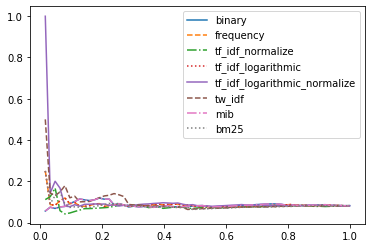

Requête:  stanford computer science


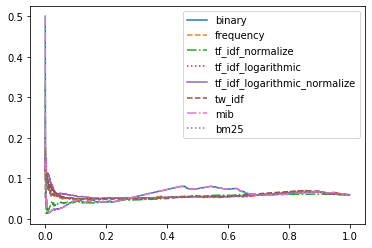

In [14]:


ordered_model_list = ["binary", "frequency"]
ordered_model_list = ["binary", "frequency", "tf_idf_normalize",
                      "tf_idf_logarithmic", "tf_idf_logarithmic_normalize",
                      'tw_idf', 'mib', 'bm25']


for query in requests:
    print('Requête: ', query)
    inc = 0

    for model_name in ordered_model_list:
        model = get_model(model_name, 'binary',
                          stats_collection, index_weight=indegree_corpus)
        ls = ['-', '--', '-.', ':'][inc % 4]
        draw_recall_precision_curve(
            query, inverted_index, model, relevance_judgments, model_name=model_name, linestyle=ls)
        inc += 1
    plt.legend()
    plt.show()



 **Observations**:
 + La précision ne finit jamais en dessous de celle du modèle booléen 'OR'. C'est cohérent avec le fait que ces modèles renvoient le même ensemble de document, il suffit qu'un des termes de la requête soit présent dans le document pour que celui-ci ai un score. La précision finit plus élevée que le modèle 'OR' lorsque le document le moins bien classé n'est pas pertinent, on peut le voir par le fonctionnement de l'algorithme de calcul de la précision et du rappel.

 + Comme on s'y attendait pour la requête 'stanford computer science' la courbe précision-rappel est très mauvaise, c'est presque comme si on cherchait des résultats sur la programmation en tapant 'stanford' comme requête, la précision est faible même pour de faibles valeurs du rappel. La précision est toutefois élevée aux valeurs du rappel proche de zéro donc quelques documents au début du classement seront pertinents.
 + Pour la requête 'very cool', la courbe est plus ou moins constante sauf pour des valeurs du rappel très proche de zéro. On note cependant que le modèle TW-IDF de l'article a des valeurs de précision supérieures à la valeur limite lorsque le rappel est plus petit que 0.3.
 + Les modèles fréquentiel et TF-IDF logarithmique ont la même courbe pour la requête 'very cool', qui donne après filtrage des stop words, 'cool'. En effet, il suffit de montrer que TF-IDF logarithmique est une fonction croissante de TF dans le cas où il n'y a qu'un seul terme puisque l'unique terme fait que le score de tous les document vaut $(1+\log{tf})*\log{\frac{N}{df}}$ . Le terme IDF est le même pour tous les documents car on un seul terme dans la requête et le facteur TF ne dépend que de tf et est croissant en tf. Ainsi pour un seul terme il est cohérent d'avoir égalité des courbes entre les modèes fréquentiel et TF-IDF logarithmique.

 + Les modèles binaire et MIB donnent les mêmes résultats. Or avec les approximations qu'on a faite pour MIB, on a cj = $\log{\frac{1}{1-\frac{d_{f_{j}}}{N}}}$ qui est une constante pour tous les documents qui contiennent le terme en position j. Ainsi pour une requête à un terme, tous les documents possèdant le terme ont le score c1 et les autres le score 0, c'est le même comportement que le modèle binaire et même s'il n'y a pas la notion de classement vu que le score prend seulement deux valeurs possibles, il est cohérent que l'algorithme renvoie le même résultat de précision-rappel pour les deux modèles.
 Cependant pour les requêtes à deux termes, on a 3 possibilités, soit le document a les deux termes, soit l'un des deux. Ainsi les modèles MIB et binaires devrait avoir le meme comportement pour les documents qui ont les deux termes ou aucun mais pour les documents qui ne possèdent qu'un terme, ceux qui possèdent le terme le plus présent devraient être favorisés ce qui pourrait changer l'ordre des documents. En l'occurence le code ci-dessous montre que le terme le plus présent, donc donnant le meilleur score lorsque seul un terme de la requête est présent, est le terme 'stanford'. Le modèle binaire ici donne le même ordre par coup de chance: dans la fonction **processing_vectorial_query**, les termes sont traités dans l'ordre où ils sont dans la requête. Ainsi, comme c'était 'stanford' à chaque fois, la fonction met dans le dictionnaire trié d'abord les documents contenant 'stanford' et les documents contenant le deuxième terme ensuite. Ainsi les documents contenant seulement le terme 'stanford' sont naturellement classé avant, seuls les documents contenant les deux termes à la fois sont replacé au début du dictionnaire ce que fait aussi le modèle MIB. Ainsi les deux modèles donnent les mêmes résultats dans notre cas précis.


In [15]:

processed_requests = []
for query in requests:
    processed = pre_processed_query(query, inverted_index)
    if len(processed) > 1:
        processed_requests.append(processed)

for query in processed_requests:
    print('Requête', query)

    for term in query:
        print(term, len(inverted_index[term]))
    term1 = query[0]
    term2 = query[1]
    s1 = set(inverted_index[term1].keys())
    s2 = set(inverted_index[term2].keys())
    print('intersection', len(s1.intersection(s2)))
    print('')



Requête ['stanford', 'class']
stanford 71276
class 10202
intersection 8268

Requête ['stanford', 'student']
stanford 71276
student 29686
intersection 27949

Requête ['stanford', 'computer']
stanford 71276
computer 55
intersection 41



 Fonctions de calcul et de tracé de l'interpolation de la précision et de sa moyenne sur les requêtes

In [16]:


def interpolate_precision(value, results_precision, results_recall):
    inc = 0
    while inc < len(results_recall) and results_recall[inc] < value:
        inc += 1
    if len(results_precision[inc:]) == 0:
        return(0)
    else:
        precision = max(results_precision[inc:])
        return(precision)


def make_interpolated_list(query, inverted_index, model, relevance_judgments, values=[i * 0.1 for i in range(11)]):
    interpolated_precision_list = []

    precision_list, recall_list = run_model_and_evaluate(
        query, inverted_index, model, relevance_judgments)

    for value in values:
        precision = interpolate_precision(value, precision_list, recall_list)
        interpolated_precision_list.append(precision)

    return(interpolated_precision_list, values)


def draw_interpolate_recall_precision_curve(query, inverted_index, model, relevance_judgments, model_name=None):
    precision_list, recall_list = run_model_and_evaluate(
        query, inverted_index, model, relevance_judgments)
    precision_list, recall_list = make_interpolated_list(
        query, inverted_index=inverted_index, model=model, relevance_judgments=relevance_judgments)
    plt.plot(recall_list, precision_list, label=model_name)


def draw_interpolate_recall_precision_curve_test_collection(requests, inverted_index, model, relevance_judgments, model_name=None, linestyle=None):
    precision_results = []
    for query in requests:
        precision_list, recall_list = run_model_and_evaluate(
            query, inverted_index, model, relevance_judgments)
        precision_list, values = make_interpolated_list(
            query, inverted_index=inverted_index, model=model, relevance_judgments=relevance_judgments)
        precision_results.append(precision_list)
    precision_results = np.array(precision_results)
    precision_average = np.mean(precision_results, axis=0)
    plt.plot(values, precision_average, label=model_name, linestyle=linestyle)
    return(values, precision_average)



 #### Précision moyenne

 Evaluation du résultat d'une requête à l'aide de sa précision moyenne qui est la moyenne des valeurs de précision des documents pertinents par rapport à la requête dans la liste ordonnée des résultats.
 $$ AveP(q) = \frac{1}{n_{+}^{q}} \sum_{k=1}^{N} R_{d_k,q} \times P@k(q)$$ avec $n_{+}^{q}$ le nombre total de documents pertinents par rapport à $q$ et $P@k(q) = \frac{1}{k} \sum_{rg=1}^{k} R_{d_{rg},q}$


In [17]:


def mean_precision(query, doc_is_relevant, k, doc_list):
    '''cette fonction calcule le kième terme de la précision moyenne
    inutilisée dans la fonction suivante pour des raisons de performance
    En effet, dans cumulated_mean_precision, le calcul des valeurs renvoyées par mean_precision 
    ne sont pas indépendants ce qui permet un gain de performance.'''
    doc = doc_list[k - 1]

    if doc_is_relevant[doc] == 0:
        return(0)
    else:
        res = 0
        for i in range(k - 1):
            doc_i = doc_list[i]
            res += doc_is_relevant[doc_i]
        res = res / k
        return (res)


def cumulated_mean_precision(query, inverted_index, model, relevance_judgments):
    '''Calcule la précision moyenne en appliquant la fonction précédente pour 
    chaque k allant de 1 au nombre de documents renvoyés par la requête'''
    relevance_judgments = relevance_judgments[query]

    sorted_estimate = model(query, inverted_index)
    doc_list = list(sorted_estimate.keys())

    doc_is_relevant = {}
    for doc in doc_list:
        if doc in relevance_judgments:
            doc_is_relevant[doc] = 1
        else:
            doc_is_relevant[doc] = 0

    n = len(relevance_judgments)
    N = len(sorted_estimate)

    res = 0
    pertinent_doc_count = 0
    for k in range(1, N + 1):
        doc_k = doc_list[k - 1]

        pertinent_doc_count += doc_is_relevant[doc_k]

        if doc_is_relevant[doc_k] == 0:
            continue
        else:
            term = pertinent_doc_count / k

        res += term
    res = res / n

    return(res)



 ### Moyenne des précisions moyennes

 $$MAP = \frac{1}{|Q|}\sum_{j=1}^{|Q|} AveP(q_j)$$
 La fonction ci dessous permet de calculer cette valeur

In [18]:


def mean_average_precision(requests, inverted_index, model, relevance_judgments):
    res = 0
    for query in requests:
        query_mean_precision = cumulated_mean_precision(
            query, inverted_index, model, relevance_judgments)
        res += query_mean_precision
    res = res / len(requests)
    return (res)



 ### APPLICATION ET EVALUATION SUR LES MODELES

 Comparaisons des courbes précision-rappel interpolées et de la précision moyenne, moyennée sur l'ensemble des requêtes, pour l'ensemble des modèles testés qu'on rappel ci-dessous:
   + La pondération `tf`.
   + La pondération `tf-idf`.
   + La pondération `tf-idf` normalisée.
   + La pondération `tf-idf` logarithmique.
   + La pondération `tf-idf` logarithmique normalisée.
   + La pondération `tw-idf`
   + le modèle `MIB`
   + le modèle `BM25`


binary model took 1.5983858108520508 seconds to compute metrics
frequency model took 2.0334622859954834 seconds to compute metrics
tf_idf_normalize model took 3.4298038482666016 seconds to compute metrics
tf_idf_logarithmic model took 3.1370315551757812 seconds to compute metrics
tf_idf_logarithmic_normalize model took 3.409752130508423 seconds to compute metrics
tw_idf model took 3.536186456680298 seconds to compute metrics
mib model took 2.3796534538269043 seconds to compute metrics
bm25 model took 3.5581212043762207 seconds to compute metrics


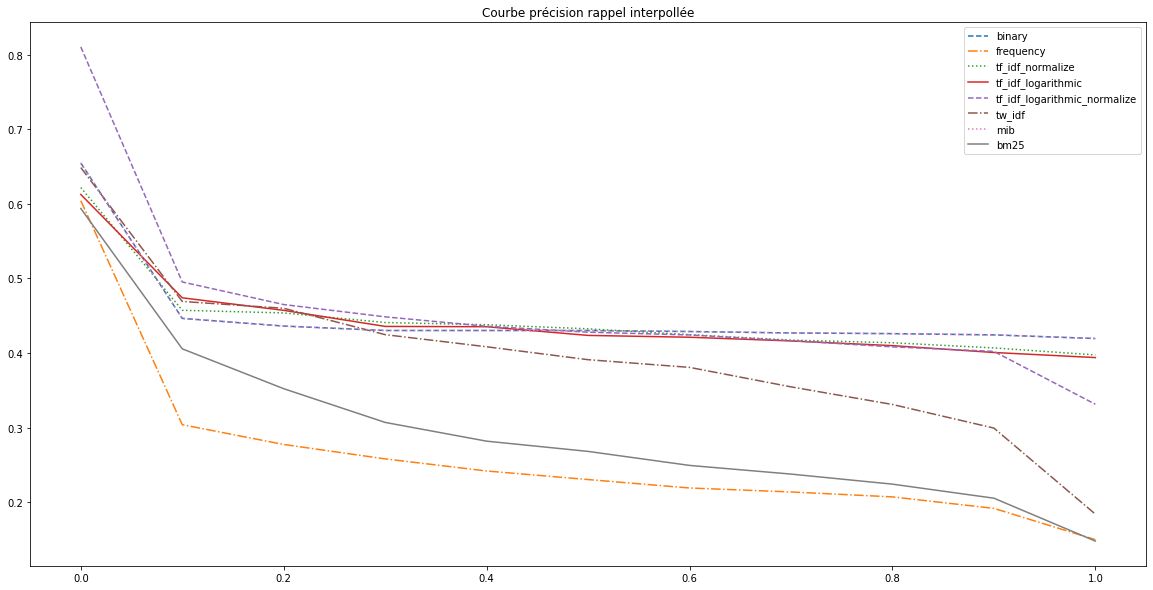

mean_precision
frequency                           0.233969
bm25                                0.280571
tw_idf                              0.386559
binary                              0.410022
mib                                 0.410022
tf_idf_logarithmic                  0.423864
tf_idf_normalize                    0.428481
tf_idf_logarithmic_normalize        0.438967


In [19]:
import time


map_models_to_querymodels_to_metrics = {}
map_models_to_querymodels_to_metrics['mean_precision'] = {}

query_model = 'binary'
inc = 0

plt.figure(figsize=(20, 10))


for model_name in ordered_model_list:
    inc += 1
    t1 = time.time()
    model = get_model(model_name, query_model,
                      stats_collection=stats_collection, index_weight=indegree_corpus)
    ls = ['-', '--', '-.', ':'][inc % 4]
    m_precision = mean_average_precision(
        requests, inverted_index, model, relevance_judgments)
    precision_recall = draw_interpolate_recall_precision_curve_test_collection(
        requests, inverted_index, model, relevance_judgments, model_name=model_name, linestyle=ls)

    map_models_to_querymodels_to_metrics['mean_precision'][model_name] = m_precision
    print(model_name + ' model took ' +
          str(time.time() - t1) + ' seconds to compute metrics')
plt.legend()
plt.title('Courbe précision rappel interpollée')
plt.show()

import pandas as pd

df = pd.DataFrame(map_models_to_querymodels_to_metrics)
df = df.sort_values(by='mean_precision')
print(df)

 On constate que les 5 meilleurs modèles ici, pour la courbe précision-rappel et la précision moyenne, sont les TF-IDF, binaire et MIB avec un modèle TW-IDF un peu moins performant. Les modèles BM25 et fréquentiels ont été moins performants.

 **CONCLUSION**

 Les modèles sont parvenu à bien traiter 2 requêtes et moins bien les deux restantes. Tandis que cela est compréhensible pour la requête 'very cool' qu'on peut considérer comme plus subjective et donc variable suivant les individus, c'est moins le cas pour la requête 'stanford computer science'. Une méthode pourrait être d'utiliser le pouvoir d'apprentissage des modèles probabilistes pour capturer ce champ lexical depuis les documents contenant le terme 'computer'. Mais on peut penser que cela ne suffira pas au vu des faibles valeur de rappel et précision de la requête 'computer'. Une autre façon de faire pourrait être d'utiliser l'augmentation de requête qui permettrait d'inclure le champ lexical et abréviations liées aux computer sciences.

 Pour finir le code ci-dessous renvoie un dictionnaires qui, pour chaque nom de modèle, renvoie la liste des documents retenus pour la concaténation des requêtes précédente selon le modèle de requête choisi; fréquentiel ou binaire.

In [20]:
concatenated_request = ''
for query in requests:
    concatenated_request += query

concatenated_request = concatenated_request[:-1]

# rappel de la liste des modèles booléens utilisés
model_list = ['bool_and', 'bool_or']

# la liste des modèles qui renvoient des documents pertinents ordonnés
ordered_model_list = ["binary", "frequency", "tf_idf_normalize",
                      "tf_idf_logarithmic", "tf_idf_logarithmic_normalize",
                      'tw_idf', 'mib', 'bm25']

# les modèles de requêtes
query_model_list = ["binary", "frequency"]

all_models = model_list + ordered_model_list

result_dict = {}

for model_name in ordered_model_list:
    result_dict[model_name] = {}
    for query_model in query_model_list:
        model = get_model(model_name, query_model=query_model,
                          stats_collection=stats_collection, index_weight=indegree_corpus)
        sorted_estimate = model(query, inverted_index)
        result_dict[model_name][query_model] = sorted_estimate
for model_name in model_list:
    model = get_model(model_name, query_model=query_model,
                      stats_collection=stats_collection, index_weight=indegree_corpus)
    estimate = model(concatenated_request, inverted_index)
    result_dict[model_name] = estimate
print(
    "Pour obtenir les résultats d'un modèle, demandez la variable result_dict[model_name][query_model] ou result_dict[model_name] si c'est un modèle booléen.")

print("\nComparaison des longueurs des ensembles renvoyés pour les différents modèles")

print('Modèle AND', len(result_dict['bool_and']))
print('Modèle TW-IDF', len(result_dict['tw_idf']['binary']))
print('Tous les autres', len(result_dict['bool_or']))


Pour obtenir les résultats d'un modèle, demandez la variable result_dict[model_name][query_model] ou result_dict[model_name] si c'est un modèle booléen.

Comparaison des longueurs des ensembles renvoyés pour les différents modèles
Modèle AND 19
Modèle TW-IDF 70809
Tous les autres 72542


 **RQ** : Le modèle TW-IDF renvoie moins de documents sur le modèle OR car on travaille sur l'index inversé des degrés entrants or les mots qui apparaissent au début des documents et jamais ailleurs n'y sont pas alors qu'ils sont dans l'index inversé fréquent. Les documents obtenus pour TW-IDF sont finalement ceux d'un modèle OR appliqué à l'index inversé des degrés entrant qui possède moins de terme que l'index inversé fréquentiel.